In [113]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

from time import time
%matplotlib inline

In [2]:
# download CIFAR-10 dataset from: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2018-03-14 04:21:21--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  17.1MB/s    in 7.8s    

2018-03-14 04:21:28 (20.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
!mv cifar-10-python.tar.gz /datasets/cifar-10-python.tar.gz
# move wherever your want and set the CIFAR_DIR variable

In [0]:
def unpickle(file):
    CIFAR_DIR = "datasets/cifar-10-batches-py/"
    with open(CIFAR_DIR + file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
dirs = ['batches.meta', 'data_batch_1', 'data_batch_2', 
        'data_batch_3', 'data_batch_4', 'data_batch_5',
        'test_batch']

batch_meta = unpickle(dirs[0])
data_batch1 = unpickle(dirs[1])
data_batch2 = unpickle(dirs[2])
data_batch3 = unpickle(dirs[3])
data_batch4 = unpickle(dirs[4])
data_batch5 = unpickle(dirs[5])
test_batch = unpickle(dirs[6])
    

In [8]:
batch_meta

{b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_cases_per_batch': 10000,
 b'num_vis': 3072}

In [0]:
# the shape of the images is stored in row major
# that's why we need to transpose it according
# to our channels

X = data_batch1[b"data"].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("uint8")

(32, 32, 3)

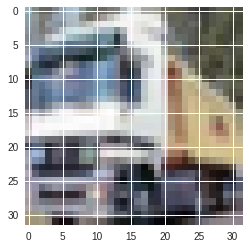

In [10]:
# Show random image

plt.imshow(X[1])
X[1].shape

In [0]:
class CIFARSetup():
    def __init__(self):
        self.training_images = None
        self.training_labels = None
        self.testing_images = None
        self.testing_labels = None
        self.train_batches = [data_batch1, data_batch2, data_batch3,
                        data_batch4, data_batch5]
        self.test_batch = test_batch
        self.training_size = 0
        self.yield_counter = 0
        self.consolidate()
        
    def one_hot_encode(self, inp, columns=10):
        rows = len(inp)
        one_hot = np.zeros((rows, columns))
        one_hot[range(rows), inp] = 1
        return one_hot
    
    def consolidate(self):
        # consolidate all the images in rows
        self.training_images = np.vstack((d[b"data"] 
                                          for d in self.train_batches))
        train_length = len(self.training_images)
        self.training_size = train_length
        # Reshape and normalize
        self.training_images = self.training_images \
                                   .reshape(train_length, 3, 32, 32) \
                                   .transpose(0, 2, 3, 1) / 255
        
        # consolidate all image labels in column (horizontally)
        labels_in_column = np.hstack((d[b"labels"] 
                                        for d in self.train_batches))
        
        # one hot encode them
        self.training_labels = self.one_hot_encode(labels_in_column)
        
        # Testing
        # consolidate all the images in rows
        self.testing_images = self.test_batch[b"data"]
        test_length = len(self.testing_images)
        
        # Reshape and normalize
        self.testing_images = self.testing_images \
                                   .reshape(test_length, 3, 32, 32) \
                                   .transpose(0, 2, 3, 1) / 255
        self.testing_images = self.testing_images.reshape(test_length,
                                                         32, 32, 3)
        # consolidate all image labels in column (horizontally)
        labels_in_column = self.test_batch[b"labels"]
        
        # one hot encode them
        self.testing_labels = self.one_hot_encode(labels_in_column)
    
    def next_batch(self, batch_size):
        # we need to reshape it to (32, 32, 3) since that'll
        # be the format for conv2d
        batch_x = self.training_images[self.yield_counter: 
                                       self.yield_counter + batch_size] \
                      .reshape(batch_size, 32, 32, 3)
        batch_y = self.training_labels[self.yield_counter: 
                                       self.yield_counter + batch_size]
        self.yield_counter = (self.yield_counter + batch_size) % self.training_size
        return batch_x, batch_y

In [0]:
class ConvolutionalNeuralNetwork:
    def __init__(self):
        """
        Parameters
        ----------
        X : Input tensor with dimensions: 
            [batch, height, width, channels]
        """
        self.X = tf.placeholder(tf.float32, 
                                shape=[None, 32, 32, 3])
        self.y = tf.placeholder(tf.float32, shape=[None, 10])
        self.dropout_prob = tf.placeholder(tf.float32)
        self.cifar_setup = CIFARSetup()
    
    def init_weights_and_bias(self, weights_shape, bias_shape):
        """ Randomly initializes biases and weights
        
        Parameters
        ----------
        weights_shape : shape of the weights Tensor.
        
        bias_shape : shape of the bias Tensor.
        """
        rand_dist = tf.truncated_normal(weights_shape, stddev=0.1)
        W = tf.Variable(rand_dist)
        consts = tf.constant(0.1, shape=bias_shape)
        b = tf.Variable(consts)
        return W, b
        
    def conv2d(self, X, kernel):
        """Performs 2D convolution
        
        Parameters
        ----------
        X : Input tensor with dimensions: 
            [batch, height, width, channels]
            
        kernel : Kernel tensor with dimensions:
            [filter height, filter width, channels in, 
                channels out]
        """
        # strides indicate the step of CNN to move in 
        # either direction or the number of steps to 
        # take in every dimension
        strides = [1, 1, 1, 1]
        return tf.nn.conv2d(X, kernel, strides, padding="SAME")
    
    def max_pooling(self, X):
        """Performs 2x2 Max Pooling
        
        Parameters
        ----------
        X : Input tensor with dimensions: 
            [batch, height, width, channels]
        """
        # ksize is the size of the window for 
        # each dimension of the inpuy since we are 
        # performing 2x2 pooling and our dimensions 
        # are [batch, height, width, channels] we
        # need 2 for height and width
        ksize = [1, 2, 2, 1]
        
        # same holds for strides, the only 
        # difference is strides is the step. Since we are
        # taking 2x2 pooling we need to increment our
        # step by 2 after every max pooling step.
        strides = [1, 2, 2, 1]
        return tf.nn.max_pool(X, ksize=ksize, strides=strides,
                              padding="SAME")
        
    def convolution_layer(self, X, shape):
        """Creates a Convolutional Layer
        
        Parameters
        ----------
        X : Input tensor with dimensions: 
            [batch, height, width, channels]
        
        shape : Shape of the Kernel with dimensions:
            [filter height, filter width, channels in, 
                channels out]
        """
        W, b = self.init_weights_and_bias(weights_shape=shape,
                                          bias_shape=[shape[3]])
        return tf.nn.relu(self.conv2d(X, W) + b)
    
    def dense_layer(self, input_layer, size):
        """ Creates a Fully Connected Layer
        
        Parameters
        ----------
        input_layer : Tensor of the previous layer.
        
        size : output size of the fully connected layer. 
        
        Returns
        -------
        Tensor output of the fully connected layer. 
        """
        input_layer_size = int(input_layer.get_shape()[1])
        W, b = self.init_weights_and_bias(weights_shape=
                                          [input_layer_size, size],
                                          bias_shape=[size])
        return tf.matmul(input_layer, W) + b
        
    def forward_pass(self):
        """ Performs a forward pass and outputs probabilities """
        # Reshape the image (None, 784) back to (-1, 28, 28, 1)
        X_image = self.X
        
        ################### Layer 1 (CNN) ###########################
        
        cnn_layer_1 = self.convolution_layer(X_image, 
                                             shape=[4, 4, 3, 32])
        cnn_layer_1_pooled = self.max_pooling(cnn_layer_1)
        
        ################### Layer 2 (CNN) ###########################
        
        cnn_layer_2 = self.convolution_layer(cnn_layer_1_pooled, 
                                             shape=[4, 4, 32, 64])
        cnn_layer_2_pooled = self.max_pooling(cnn_layer_2)
        
        ################### Layer 3 (Dense) ##########################
        
        cnn_layer_2_flat = tf.reshape(cnn_layer_2_pooled, (-1, 8*8*64))
        dense_layer_1 = tf.nn.relu(self.dense_layer(cnn_layer_2_flat, 1024))
        
        ######################## Dropout #############################
        
        dense_layer_1_drop = tf.nn.dropout(dense_layer_1, 
                                           keep_prob=self.dropout_prob)
        
        ######################## Predict #############################
        
        return self.dense_layer(dense_layer_1_drop, 10)
    
    def train(self):
        """ Trains the CNN using AdamOptimizer """
        y_pred = self.forward_pass()
        cross_entropy_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=self.y,
                                                    logits=y_pred))
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_cnn = optimizer.minimize(cross_entropy_loss)
        init = tf.global_variables_initializer()
        steps = 2001
        
        with tf.Session() as sess:
            sess.run(init)
            for step in range(steps):
                start_time = time()
                X_batch, y_batch = self.cifar_setup.next_batch(50)
                sess.run(train_cnn, feed_dict={self.X: X_batch, self.y: y_batch,
                                               self.dropout_prob: 0.5})
                matches = tf.equal(tf.argmax(y_pred, 1), tf.argmax(self.y, 1))
                accuracy = tf.reduce_mean(tf.cast(matches, tf.float32))
                result = sess.run(accuracy, 
                                  feed_dict={self.X: self.cifar_setup.testing_images, 
                                             self.y: self.cifar_setup.testing_labels,
                                             self.dropout_prob: 1.0})
                if step % 100 == 0:
                    print("Step: {0} Accuracy: {1:.2f}% Time: {2:.2f} secs/step"
                          .format(step, result * 100, time() - start_time))

In [14]:
ConvolutionalNeuralNetwork().train()

Step: 0 Accuracy: 10.05% Time: 0.69 secs/step
Step: 100 Accuracy: 33.49% Time: 0.54 secs/step
Step: 200 Accuracy: 40.57% Time: 0.55 secs/step
Step: 300 Accuracy: 44.67% Time: 0.64 secs/step
Step: 400 Accuracy: 45.77% Time: 0.58 secs/step
Step: 500 Accuracy: 49.31% Time: 0.61 secs/step
Step: 600 Accuracy: 51.97% Time: 0.63 secs/step
Step: 700 Accuracy: 52.69% Time: 0.65 secs/step
Step: 800 Accuracy: 53.75% Time: 0.67 secs/step
Step: 900 Accuracy: 54.67% Time: 0.68 secs/step
Step: 1000 Accuracy: 57.66% Time: 0.71 secs/step
Step: 1100 Accuracy: 55.69% Time: 0.72 secs/step
Step: 1200 Accuracy: 56.11% Time: 0.74 secs/step
Step: 1300 Accuracy: 58.17% Time: 0.77 secs/step
Step: 1400 Accuracy: 59.64% Time: 0.78 secs/step
Step: 1500 Accuracy: 59.46% Time: 0.81 secs/step
Step: 1600 Accuracy: 60.85% Time: 0.83 secs/step
Step: 1700 Accuracy: 61.44% Time: 0.87 secs/step
Step: 1800 Accuracy: 59.50% Time: 0.93 secs/step
Step: 1900 Accuracy: 62.27% Time: 0.92 secs/step
Step: 2000 Accuracy: 64.08% Time